In [1]:
import torch.nn as nn
import torch
import numpy as np
from torch.optim import Adam
import random
import gymnasium as gym
import matplotlib.pyplot as plt
import time
from collections import deque


In [2]:
class DQN(nn.Module):

    def __init__(self, n_states, n_actions):
        super().__init__()
        self.n_states = n_states
        self.n_actions = n_actions

        self.network = nn.Sequential(
            nn.Linear(self.n_states, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.n_actions)
        )

    def forward(self, states):
        return self.network(states)
    
    def get_qvalues(self, states):
        states = torch.tensor(states)
        qValues = self.forward(states)
        return qValues.cpu().numpy()

In [11]:
class ReplayBuffer:
    
    def __init__(self, gamma=0.9, steps = 5,size=20000):
        self.size = size
        self.gamma = gamma
        self.steps = steps
        
        self.buffer = deque(maxlen = size)
        self.n_step_buffer = deque(maxlen = steps)


    def __len__(self):
        return len(self.buffer)
    

    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        self.n_step_buffer.append(item)
        if len(self.n_step_buffer) < self.steps and not done: 
            return 

        state, action = self.n_step_buffer[0][:2]
        R = 0
        for idx, (_, _, r, n_s, d) in enumerate(self.n_step_buffer):
            R += (self.gamma ** idx) * r
            if d or idx == self.steps - 1:
                next_state, done, steps = n_s, d, idx + 1
                break

        self.buffer.append((state, action, R, next_state, done, steps))
        
                

    def sample(self, batch_size):
        idx = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idx]
        return list(zip(*samples))

In [20]:
class Agent:

    def __init__(self,env, n_states, n_actions, gamma=0.9, episilon = 1, episilon_decay = 0.995, episilon_min = 0.01):
        
        self.env = env
        self.n_states = n_states
        self.n_actions = n_actions
        
        self.gamma = gamma
        self.episilon = episilon
        self.episilon_decay = episilon_decay
        self.episilon_min = episilon_min
        self.steps = 0
        self.target_update_freq = 100
        self.batch_size = 64

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQN(n_states, n_actions)
        self.policy_net.to(self.device)
        self.target_net = DQN(n_states, n_actions)
        self.target_net.to(self.device)
        self.buffer = ReplayBuffer()

        self.policy_net.to(self.device)
        self.target_net.to(self.device)

        self.optimizer = Adam(self.policy_net.parameters(), lr = 0.0001)
        self.loss = nn.MSELoss()
        self.addMemory()
        
    
    def addMemory(self):
        sum_rewards = 0
        state = self.env.reset()[0]
        for _ in range(1000):

            action = self.env.action_space.sample()
            next_state, reward, term, trun, _ = self.env.step(action)
            done = int(term or trun)
            sum_rewards += 1
            self.buffer.add(state, action, reward, next_state, done)
            if done:
                state = self.env.reset()[0]
            else:
                state = next_state


    def select_action(self, state):
        if random.random() < self.episilon:
            return self.env.action_space.sample()
        
        state = torch.tensor(state).to(self.device)
        with torch.no_grad():
            qValues = self.policy_net(state)
        return torch.argmax(qValues).item()


    def train(self):
        
        if len(self.buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, done, n = self.buffer.sample(self.batch_size)
        states = torch.tensor(states).to(self.device)
        actions = torch.tensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states).to(self.device)
        done = torch.tensor(done).unsqueeze(1).to(self.device)
        n = torch.tensor(n).unsqueeze(1).to(self.device)

        # print(actions.shape)
        qValue = self.policy_net(states).gather(1, actions)

        with torch.no_grad():
            target_net = self.target_net(next_states).max(1, keepdim = True)[0]
            # print(target_net.shape)
            target_qValues = rewards + (self.gamma ** n) * target_net * (1 - done)
        
        # print(qValue.shape, target_qValues.shape)
        
        loss = self.loss(qValue, target_qValues)
        self.loss_value += loss
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())



    def playingLoop(self, num_episodes = 500):
        self.num_episodes = num_episodes
        self.rewards_per_episode = []
        self.loss_per_episode = []

        for ep in range(num_episodes):
            self.loss_value = 0
            state = self.env.reset()[0]
            episode_reward = 0
            done = 0

            while not done:

                action = self.select_action(state)
                next_state, reward, term, trun, _ = self.env.step(action)
                done = int(term or trun)
                self.buffer.add(state, action, reward, next_state, done)

                self.train()

                state = next_state
                episode_reward += reward


            # print((1-self.episilon_decay) * self.episilon)   
            self.episilon = max(self.episilon_min, self.episilon_decay * self.episilon)
            self.rewards_per_episode.append(episode_reward)
            self.loss_per_episode.append(self.loss_value.item())

            if ep % 50 == 0:
                avg_reward = np.mean(self.rewards_per_episode[-10:])
                print(f"Episode {ep} | Avg Reward: {avg_reward:.2f} | Epsilon: {self.episilon:.2f}")

    def plot(self, interval = 50):
        moving_average_rewards = np.convolve(self.rewards_per_episode, np.ones(interval)/interval, mode = "same")
        moving_average_loss = np.convolve(self.loss_per_episode, np.ones(interval)/interval, mode = "same")
        plt.plot(range(self.num_episodes), moving_average_rewards, label = "Moving Average")
        plt.plot(range(self.num_episodes), moving_average_loss, label = "Loss Per Episode")
        plt.xlabel("Episodes")
        plt.ylabel("Values per episode")
        

In [21]:
episodes = 1000
env = gym.make("CartPole-v1", render_mode = "rgb_array")
agent = Agent(env, 4, 2)
rewards =agent.playingLoop(episodes)

Episode 0 | Avg Reward: 13.00 | Epsilon: 0.99
Episode 50 | Avg Reward: 41.70 | Epsilon: 0.77
Episode 100 | Avg Reward: 56.90 | Epsilon: 0.60
Episode 150 | Avg Reward: 214.30 | Epsilon: 0.47
Episode 200 | Avg Reward: 219.40 | Epsilon: 0.37
Episode 250 | Avg Reward: 190.60 | Epsilon: 0.28
Episode 300 | Avg Reward: 169.10 | Epsilon: 0.22
Episode 350 | Avg Reward: 212.50 | Epsilon: 0.17
Episode 400 | Avg Reward: 241.70 | Epsilon: 0.13
Episode 450 | Avg Reward: 210.50 | Epsilon: 0.10
Episode 500 | Avg Reward: 219.70 | Epsilon: 0.08
Episode 550 | Avg Reward: 238.30 | Epsilon: 0.06
Episode 600 | Avg Reward: 223.40 | Epsilon: 0.05
Episode 650 | Avg Reward: 242.30 | Epsilon: 0.04
Episode 700 | Avg Reward: 241.60 | Epsilon: 0.03
Episode 750 | Avg Reward: 243.50 | Epsilon: 0.02
Episode 800 | Avg Reward: 444.70 | Epsilon: 0.02
Episode 850 | Avg Reward: 219.30 | Epsilon: 0.01
Episode 900 | Avg Reward: 186.30 | Epsilon: 0.01
Episode 950 | Avg Reward: 272.10 | Epsilon: 0.01


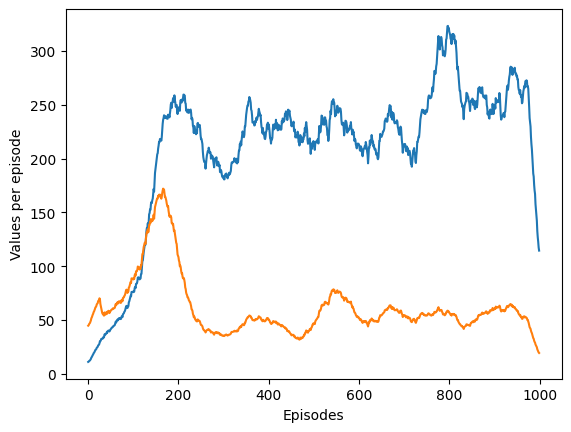

In [22]:
agent.plot()

In [28]:
env = gym.make("CartPole-v1", render_mode = "rgb_array")
state, _ = env.reset()
done = False
policy_net = agent.policy_net
policy_net.eval()
total_reward = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

while not done:
    with torch.no_grad():
        state = torch.tensor(state).unsqueeze(0).to(device)
        action = torch.argmax(policy_net(state)).item()
    # print(action)
    next_state, reward, term, trun, _  = env.step(action)
    total_reward += reward
    done = term or trun
    state = next_state
    # time.sleep(0.1)
print(total_reward)

395.0
